In [1]:
pwd

'C:\\Users\\bjs66'

In [2]:
# -*- coding: utf-8 -*-

# 딥러닝 관련 Keras 라이브러리
import keras
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.preprocessing.image import ImageDataGenerator

# File I/O
import subprocess
import shutil
import os
from glob import glob
from datetime import datetime
import argparse

# 데이터 처리
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# 이미지 처리
import cv2
from scipy.ndimage import rotate
import scipy.misc



In [9]:
# 학습 파라미터를 설정한다


import easydict

args = easydict.EasyDict({
 
        "data_augment": 0,
 
        "random_split": 1,
    
        "batch_size": 8,
 
        "semi_train": None,
 
        "learning_rate": 1e-4,
 
        "weights": 'None',
    
        "model" : 'vgg16'
 
    
})


fc_size = 2048
n_class = 10
seed = 10
nfolds = 5
test_nfolds = 3
img_row_size, img_col_size = 224, 224
train_path = 'section4/project/state-farm-distracted-driver-detection/imgs/train'

"""
if args.semi_train is not None:
    train_path = args.semi_train
    args.semi_train = True
    
"""

test_path = 'section4/project/state-farm-distracted-driver-detection/imgs/test'
labels = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']



suffix = 'm{}.w{}.lr{}.s{}.nf{}.semi{}.b{}.row{}col{}.rsplit{}.augment{}.d{}'.format(args.model, args.weights, args.learning_rate, seed, nfolds, args.batch_size,args.semi_train, img_row_size, img_col_size, args.random_split, args.data_augment, datetime.now().strftime("%Y-%m-%d-%H-%M"))
temp_train_fold = '../train_{}'.format(suffix)
temp_valid_fold = '../valid_{}'.format(suffix)
cache = '../cache/{}'.format(suffix)
subm = '../subm/{}'.format(suffix)



In [4]:
print('# Data Load')
drivers = pd.read_csv('section4/project/state-farm-distracted-driver-detection/driver_imgs_list.csv')
img_to_driver = {}
uniq_drivers = []

for i, row in drivers.iterrows():
    label_n_driver = {}
    label_n_driver['label'] = row['classname']
    label_n_driver['driver'] = row['subject']
    img_to_driver[row['img']] = label_n_driver

    if row['subject'] not in uniq_drivers:
        uniq_drivers.append(row['subject'])

# Data Load


In [5]:
# import
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.vgg16 import VGG16

In [6]:
# VGG16 모델 정의

def get_model():

  # 최상위 전결층을 제회한 vgg16 모델 불러오기
  base_model = VGG16(include_top= False, weights=None, input_shape=(224,224,3))

  # 최상위 전결층 정의하기
  X = Flatten()(base_model.output)
  X = Dense(2048, activation='relu')(X)
  X = Dropout(0.5)(X)
  X = Dense(2048, activation='relu')(X)
  X = Dropout(0.5)(X)
  output = Dense(10, activation='softmax')(X) # 다중분류이므로 softmax 함수 사용한다.

  model = Model(inputs=base_model.input, outputs=output)

  # SGD optimizer를 사용하여, 모델 compile하기

  sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [42]:
# mkdir imgs

In [7]:
# 이미지 데이터 전처리를 수행하는 함수를 정의한다
# 실시간 전처리를 추가할 경우, 전처리 함수를 설정값에 넣어준다
if args.data_augment:
    datagen = ImageDataGenerator(preprocessing_function=preprocess)
else:
    datagen = ImageDataGenerator()

# 테스트 데이터를 불러오는 ImageGenerator를 생성한다
test_generator = datagen.flow_from_directory(
        directory = 'section4/project/state-farm-distracted-driver-detection/imgs/test',
        target_size=(img_row_size, img_col_size),
        batch_size=1,
        class_mode=None,
        shuffle=False)
test_id = [os.path.basename(fl) for fl in glob('{}/imgs/*.jpg'.format(test_path))]


# 특정 폴더에 위치해 있는 훈련/ 검증 데이터를 실시간으로 읽어온다

train_generator = datagen.flow_from_directory(
            directory= 'section4/project/state-farm-distracted-driver-detection/imgs/train',
            target_size=(224,224),
            batch_size=8,
            class_mode='categorical',
            seed=2018)

valid_generator = datagen.flow_from_directory(
            directory='section4/project/state-farm-distracted-driver-detection/imgs/valid',
            target_size=(224,224),
            batch_size=8,
            class_mode='categorical',
            seed=2018)

Found 79726 images belonging to 1 classes.
Found 20184 images belonging to 10 classes.
Found 2240 images belonging to 10 classes.


In [11]:
def _clear_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)
#for path in [temp_train_fold, temp_valid_fold, cache, subm]:
#    _clear_dir(path)

In [12]:
# 교차검증 평가 준비
# 5-fold stratifiedkfold 기법


from glob import glob
import numpy as np
import subprocess
import os

root_path = 'section4/project/state-farm-distracted-driver-detection'

def generate_split():
  # 이미지 생성기를 위하여 임시 훈련/검증 폴더를 생성한다.
  def _generate_temp_folder(root_path):
    os.mkdir(root_path)
    for i in range(n_class): # n_class =10
      os.mkdir('{}/c{}'.format(root_path, i))
      _generate_temp_folder(temp_train_fold)
      _generate_temp_folder(temp_valid_fold)

  # 임시 훈련/검증 폴더에 데이터를 랜덤하게 복사한다.

  train_samples = 0
  valid_samples = 0
  for label in labels:
    files = glob('{}/{}/*jpg'.format('section4/project/state-farm-distracted-driver-detection/imgs/train', label))
    for fl in files:
        cmd = 'cp {} {}/{}/{}'
        if np.random.randint(nfolds) != 1:
            # 데이터의 4/5를 훈련 데이터에 추가한다
            cmd = cmd.format(fl, temp_train_fold, label, os.path.basename(fl))
            train_samples += 1
        else:
            # 데이터의 1/5를 검증 데이터에 추가한다
            cmd = cmd.format(fl, temp_valid_fold, label, os.path.basename(fl))
            valid_samples += 1
        # 원본 훈련 데이터를 임시 훈련/검증 데이터에 복사한다
        subprocess.call(cmd, stderr=subprocess.STDOUT, shell=True)

  # 훈련/검증 데이터 개수를 출력한다
    print('# {} train samples | {} valid samples'.format(train_samples, valid_samples))
    return train_samples, valid_samples



In [13]:
pwd

'C:\\Users\\bjs66'

In [14]:
# 모델 학습

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import shutil


print('# Train Model')

# 이미지 데이터 전처리를 수행하는 함수를 정의한다
# datagen = ImageDataGenerator()

# 테스트 데이터를 불러오는 ImageGenerator를 생성한다.


test_generator = datagen.flow_from_directory(
          directory= 'section4/project/state-farm-distracted-driver-detection/imgs/test',
          target_size=(224,224),
          batch_size=1,
          class_mode=None,
          shuffle=False)


test_id = [os.path.basename(fl) for fl in glob('{}/imgs/*.jpg'.format(test_path))]



# 5-Fold 교차 검증을 진행한다.

for fold in range(nfolds):
  # 새로운 모델을 정의한다
  model = get_model()

  # 훈련/검증 데이터를 생성한다
  train_samples, valid_samples = generate_split()

  # 훈련/검증 데이터 생성기를 정의한다.
    
  train_generator = datagen.flow_from_directory(
            directory='section4/project/state-farm-distracted-driver-detection/imgs/train',
            target_size=(224,224),
            batch_size=8,
            class_mode='categorical',
            seed=2018)
  
  valid_generator = datagen.flow_from_directory(
            directory='section4/project/state-farm-distracted-driver-detection/imgs/valid',
            target_size=(224,224),
            batch_size=8,
            class_mode='categorical',
            seed=2018)

    
  weight_path = '../cache/{}/mini_weight.fold_{}.h5'.format(suffix, i)
  callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
    ModelCheckpoint(weight_path, monitor='val_loss', save_best_only=True, verbose=0)]



    # 모델을 학습한다. val_loss 값이 3 epoch 연속 개악되면, 학습을 멈추고 최적 weight를 저장한다
  model.fit_generator(
      train_generator,
      steps_per_epoch=train_samples/8,
      epochs=1,
      validation_data=valid_generator,
      validation_steps=valid_samples/8,
      shuffle=True,
      callbacks=callbacks,
      verbose=1)

# Train Model
Found 79726 images belonging to 1 classes.


C:\Users\bjs66\.conda\envs\project_section4\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# 1803 train samples | 438 valid samples
Found 20184 images belonging to 10 classes.
Found 2240 images belonging to 10 classes.


C:\Users\bjs66\.conda\envs\project_section4\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


225/225 [==============================] - 998s 4s/step - loss: 2.3155 - accuracy: 0.1095 - val_loss: 2.2933 - val_accuracy: 0.0977
# 1762 train samples | 479 valid samples
Found 20184 images belonging to 10 classes.
Found 2240 images belonging to 10 classes.
220/220 [==============================] - 999s 5s/step - loss: 2.3268 - accuracy: 0.1109 - val_loss: 2.2928 - val_accuracy: 0.1063
# 1761 train samples | 480 valid samples
Found 20184 images belonging to 10 classes.
Found 2240 images belonging to 10 classes.
220/220 [==============================] - 1002s 5s/step - loss: 2.3175 - accuracy: 0.1176 - val_loss: 2.2946 - val_accuracy: 0.1042
# 1761 train samples | 480 valid samples
Found 20184 images belonging to 10 classes.
Found 2240 images belonging to 10 classes.
220/220 [==============================] - 963s 4s/step - loss: 2.3202 - accuracy: 0.1126 - val_loss: 2.3024 - val_accuracy: 0.0729
# 1761 train samples | 480 valid samples
Found 20184 images belonging to 10 classes.
Fo

In [15]:
# 테스트 데이터에 대한 예측값을 생성한다.

preds = model.predict_generator(
                test_generator,
                steps=len(test_id),
                verbose=1)

C:\Users\bjs66\.conda\envs\project_section4\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


79726/79726 [==============================] - 12986s 163ms/step


In [24]:
result = pd.DataFrame(preds, columns=labels)
result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
sub_file = '../subm/vgg16.baseline/f{}.csv'.format(3)
result.to_csv(sub_file, index=False)

In [19]:
# 캐글에 제출한다
submit_cmd = 'kaggle competitions submit -c state-farm-distracted-driver-detection -f {} -m {}.fold{}'.format(sub_file, suffix, fold)
subprocess.call(submit_cmd, stderr=subprocess.STDOUT, shell=True)

# 5-Fold 교차 검증 과정에서 생성한 훈련/검증 데이터를 삭제한다
shutil.rmtree(temp_train_fold)
shutil.rmtree(temp_valid_fold)

In [25]:
print('# Ensemble')
# 5-Fold 교차 검증의 결과물을 단순 앙상블한다
ensemble = 0
for fold in range(nfolds):
    ensemble += pd.read_csv('../subm/{}/f{}.csv'.format(suffix, fold), index_col=-1).values * 1. / nfolds
ensemble = pd.DataFrame(ensemble, columns=labels)
ensemble.loc[:, 'img'] = pd.Series(test_id, index=ensemble.index)
sub_file = '../subm/{}/ens.csv'.format(suffix)
ensemble.to_csv(sub_file, index=False)

# Ensemble


FileNotFoundError: [Errno 2] No such file or directory: '../subm/mvgg16.wNone.lr0.0001.s10.nf5.semi8.bNone.row224col224.rsplit1.augment0.d2021-09-03-04-51/f0.csv'

In [ ]:
# 캐글에 제출한다
submit_cmd = 'kaggle competitions submit -c state-farm-distracted-driver-detection -f {} -m vgg16.baseline.ensemble'.format(sub_file)
subprocess.call(submit_cmd, stderr=subprocess.STDOUT, shell=True)

## 예시 이미지에 적용하기

In [29]:
pwd

'C:\\Users\\bjs66'

  => predict =  0.10956422 , class =  c5


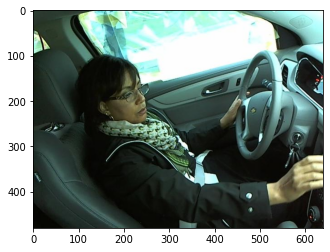

In [32]:
# 새로운 데이터로 딥러닝 모델에 적용해보기

import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import image
test_image1 = image.load_img('section4/project/state-farm-distracted-driver-detection/img_1.jpg', target_size = (224,224))
test_image2 = image.img_to_array(test_image1)
test_image2 = np.expand_dims(test_image2, axis = 0)
result_example = model.predict(test_image2) # 불러온 model 이름으로 설정하는거 주의하자.
train_generator.class_indices
if result_example[0][0] >= 0.5:
  prediction = 'mountain'
else:
  prediction = 'c5'

origin_image = image.load_img('section4/project/state-farm-distracted-driver-detection/img_1.jpg')
plt.imshow(origin_image)
print('  => predict = ', result_example[0][0], ', class = ', prediction)